# データの分布

## >> Cells With Mask
* NDAcquisition-01：45,723
* NDAcquisition-01x40：130,092
* NDAcquisition-02Nami_x20：9,096
* NDAcquisition-02Nami_x40：4,236

## >> Cells No Mask
* NDAcquisition-01：45,870
* NDAcquisition-01x40：130,147
* NDAcquisition-02Nami_x20：9,321
* NDAcquisition-02Nami_x40：4,236

# Max_shape_0 , Max_shape_1


### >> Cells 

    * 01x20
        * Max_shape_0:  234
        * Max_shape_1:  214

    * 02Namix20
        * Max_shape_0:  254
        * Max_shape_1:  234

    * 01x40
        * Max_shape_0:  464
        * Max_shape_1:  499

    * 02Namix40
        * Max_shape_0:  354
        * Max_shape_1:  274

In [11]:
import cv2,os
import numpy as np
from matplotlib import pyplot as plt

# データの読み込み

In [14]:
Data_02Nami=np.load("data/imread_02Namix40.npy",allow_pickle=True)
Data_01=np.load("data/imread_01x40.npy",allow_pickle=True)
print("Data_01.shape:", Data_01.shape)
print("Data_02Nami.shape:", Data_02Nami.shape)

Data_01.shape: (11990,)
Data_02Nami.shape: (1738,)


In [15]:
Data_01=Data_01
Data_02Nami=Data_02Nami

print("Data_01.shape:", Data_01.shape)
print("Data_02Nami.shape:", Data_02Nami.shape)

Data_01.shape: (11990,)
Data_02Nami.shape: (1738,)


# データ処理

## 1. Padding Unify the size

In [16]:
Max_shape_0 = 100
Max_shape_1 = 100

In [17]:
#　同じサイズにする 
def datapadding(data):
    DataPad=[]
    for img in data:
        imgSize = img.shape
        top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2
        left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2
        if (imgSize[0] % 2) != 0:
            top_size,bottom_size = (Max_shape_0-imgSize[0])//2,(Max_shape_0-imgSize[0])//2+1
        if (imgSize[1] % 2) != 0:     
            left_size,right_size = (Max_shape_1-imgSize[1])//2,(Max_shape_1-imgSize[1])//2+1
        img_pad = cv2.copyMakeBorder(img,top_size,bottom_size,left_size,right_size,cv2.BORDER_CONSTANT,value=(0,0,0))
        DataPad.append(img_pad)
    return DataPad

DataPad_01 = datapadding(Data_01)
DataPad_02Nami = datapadding(Data_02Nami)
print("DataPad_01: ",len(DataPad_01))
print("DataPad_02Nami: ",len(DataPad_02Nami))

DataPad_01:  11990
DataPad_02Nami:  1738


## 2. Resize by using Bin_ndarray

In [18]:
# DataBinResize = []
# def bin_ndarray(ndarray, new_shape, operation):
#     operation = operation.lower()
#     if not operation in ['sum', 'mean']:
#         raise ValueError("Operation not supported.")
#     if ndarray.ndim != len(new_shape):
#         raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
#                                                            new_shape))
#     compression_pairs = [(d, c//d) for d,c in zip(new_shape,
#                                                   ndarray.shape)]
#     flattened = [l for p in compression_pairs for l in p]
#     ndarray = ndarray.reshape(flattened)
#     for i in range(len(new_shape)):
#         op = getattr(ndarray, operation)
#         ndarray = op(-1*(i+1))
#     return ndarray

# for img in DataResize:
#     imgresize = bin_ndarray(img, new_shape=(512,512,3), operation='mean')
#     DataBinResize.append(imgresize)

In [19]:
# DataBinResize = np.array(DataBinResize)
# print("DataBinResize: ", DataBinResize.shape)

# img = cv2.imread(DataPath[1])
# print("DataPath[1].shape: ", img.shape)
# plt.imshow(img)
# plt.show()

# print("DataResize[1].shape: ", DataResize[1].shape)
# plt.imshow(DataResize[1])
# plt.show()

# print("DataBinResize[1].shape: ", DataBinResize[1].shape)
# plt.imshow(DataBinResize[1]/255)
# plt.show()

## 3. Split Train and Test

In [20]:
DataPad_01 = DataPad_01
DataLabel_01 = np.zeros(len(DataPad_01), dtype=np.int)

DataPad_02Nami = DataPad_02Nami
DataLabel_02Nami = np.ones(len(DataPad_02Nami), dtype=np.int)

/tmp/9883330.1.gpu/ipykernel_42699/4249520203.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  DataLabel_01 = np.zeros(len(DataPad_01), dtype=np.int)
/tmp/9883330.1.gpu/ipykernel_42699/4249520203.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for a

In [21]:
from sklearn.model_selection import train_test_split

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(DataPad_01, DataLabel_01,
                                                                            test_size=0.3, random_state=42)


X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(DataPad_02Nami, DataLabel_02Nami,
                                                                            test_size=0.3, random_state=42)

X_train, X_test = np.concatenate((X_train_0, X_train_1), axis = 0), np.concatenate((X_test_0, X_test_1), axis = 0)
y_train, y_test = np.concatenate((y_train_0, y_train_1), axis = 0), np.concatenate((y_test_0, y_test_1), axis = 0)

print("Total number of train : ", len(y_train))
print("train_class_0 num : ", y_train.tolist().count(0))
print("train_class_1 num : ", y_train.tolist().count(1))
print("")

print("Total number of test : ", len(y_test))
print("test_class_0 num : ", y_test.tolist().count(0))
print("test_class_1 num : ", y_test.tolist().count(1))

Total number of train :  9609
train_class_0 num :  8393
train_class_1 num :  1216

Total number of test :  4119
test_class_0 num :  3597
test_class_1 num :  522


# データ前処理

In [22]:
import torch
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
torch.__version__

'1.11.0+cu102'

In [23]:
class train_dataset(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train):
        data = x_train.astype('float32')
        self.x_train = []
        for i in range(data.shape[0]):
            self.x_train.append(Image.fromarray(np.uint8(data[i])))
        self.y_train = y_train
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.transform(self.x_train[idx]), torch.tensor(y_train[idx], dtype=torch.long)

    
class test_dataset(torch.utils.data.Dataset):
    def __init__(self, x_test, y_test):
        data = x_test.astype('float32')
        self.x_test = []
        for i in range(data.shape[0]):
            self.x_test.append(Image.fromarray(np.uint8(data[i])))
        self.y_test = y_test
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.x_test)

    def __getitem__(self, idx):
        return self.transform(self.x_test[idx]), torch.tensor(y_test[idx], dtype=torch.long)

trainval_data = train_dataset(X_train, y_train)
test_data = test_dataset(X_test, y_test)

In [24]:
batch_size = 128

val_size = int(len(trainval_data)*0.2)
train_size = len(trainval_data) - val_size
print("train_size: ",train_size)
print("val_size: ",val_size)
print("test_size: ",len(y_test))

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=True
)

train_size:  7688
val_size:  1921
test_size:  4119


# ResNet遷移学習

In [25]:
import torch
import torchvision.models as models
import torch.nn as nn

In [26]:
model = models.resnet18(pretrained=True)
num_fcs = model.fc.in_features
# FC層のクラス数を変更
model.fc = nn.Sequential(
    nn.Linear(num_fcs, 512),
    # nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, 2)
)

#Freeze model weights
for param in model.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True
    
model.avgpool = nn.AdaptiveAvgPool2d(1)
loss_func = nn.NLLLoss()
model = model.cuda()

In [27]:
n_epochs = 100

# negative : ラベル0の数
# positive : ラベル1の数
# weight_for_0 : 1. / negative * (negative + positive)
# weight_for_1 : 1. / positive * (negative + positive)
# class_weight = {0 : weight_for_0, 1 : weight_for_1}
weights = torch.tensor([(len(DataPad_01)+len(DataPad_02Nami))/len(DataPad_01), 
                        (len(DataPad_01)+len(DataPad_02Nami))/len(DataPad_02Nami)]).cuda()
loss_function = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

device = "cuda"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     model = nn.DataParallel(model)
# model.to(device)

losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]
        model.zero_grad()  # 勾配の初期化
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        loss.backward()  # 誤差の逆伝播
        optimizer.step()  # パラメータの更新
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())
    # Evaluate
    model.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]
        x = x.to(device)  # テンソルをGPUに移動
        t = t.to(device)
        y = model.forward(x)  # 順伝播
        loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))   
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_train))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(epoch,np.mean(losses_train),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

EPOCH: 0, Train [Loss: 0.900, Accuracy: 0.392], Valid [Loss: 0.651, Accuracy: 0.307]
EPOCH: 1, Train [Loss: 0.597, Accuracy: 0.639], Valid [Loss: 0.601, Accuracy: 0.544]
EPOCH: 2, Train [Loss: 3.313, Accuracy: 0.775], Valid [Loss: 0.579, Accuracy: 0.638]
EPOCH: 3, Train [Loss: 0.495, Accuracy: 0.763], Valid [Loss: 0.405, Accuracy: 0.858]
EPOCH: 4, Train [Loss: 0.429, Accuracy: 0.823], Valid [Loss: 0.563, Accuracy: 0.560]
EPOCH: 5, Train [Loss: 0.455, Accuracy: 0.807], Valid [Loss: 0.417, Accuracy: 0.859]
EPOCH: 6, Train [Loss: 0.420, Accuracy: 0.819], Valid [Loss: 0.486, Accuracy: 0.673]
EPOCH: 7, Train [Loss: 0.406, Accuracy: 0.828], Valid [Loss: 3.154, Accuracy: 0.219]
EPOCH: 8, Train [Loss: 0.454, Accuracy: 0.776], Valid [Loss: 0.774, Accuracy: 0.912]
EPOCH: 9, Train [Loss: 0.418, Accuracy: 0.821], Valid [Loss: 0.428, Accuracy: 0.741]
EPOCH: 10, Train [Loss: 0.406, Accuracy: 0.819], Valid [Loss: 0.444, Accuracy: 0.686]
EPOCH: 11, Train [Loss: 0.405, Accuracy: 0.820], Valid [Loss: 0.

EPOCH: 96, Train [Loss: 0.175, Accuracy: 0.912], Valid [Loss: 0.422, Accuracy: 0.894]
EPOCH: 97, Train [Loss: 0.154, Accuracy: 0.924], Valid [Loss: 0.493, Accuracy: 0.911]
EPOCH: 98, Train [Loss: 0.184, Accuracy: 0.922], Valid [Loss: 0.450, Accuracy: 0.907]
EPOCH: 99, Train [Loss: 0.316, Accuracy: 0.839], Valid [Loss: 0.346, Accuracy: 0.798]


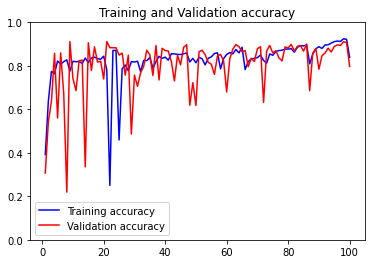

<Figure size 432x288 with 0 Axes>

In [28]:
# train processing plot
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [29]:
torch.save(model,"SelfResnet18.pkl")

In [31]:
# Test
losses_test = []
n_test = 0
acc_test = 0
model.eval()

for x, t in dataloader_test:
    n_test += t.size()[0]
    x = x.to(device)  # テンソルをGPUに移動
    t = t.to(device)
    y = model.forward(x)  # 順伝播
    loss = loss_function(y, t)  # 誤差(クロスエントロピー誤差関数)の計算
    pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする
    acc_test += (pred == t).float().sum().item()
    losses_test.append(loss.tolist())

# Visualize loss & accuracy 
print("acc_test: ", acc_test) 
print("n_test: ", n_test)
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(np.mean(losses_test),acc_test/n_test))

acc_test:  3327.0
n_test:  4119
Loss: 0.354, Accuracy: 0.808
